In [3]:
#identify available sample attributes
with open("GSE11877_series_matrix.txt", "r") as f:
    for line in f:
        if line.startswith("!Sample_title") or line.startswith("!Sample_characteristics"):
            print(line.strip())

!Sample_title	"9906_P1A02"	"9906_P1A03"	"9906_P1A04"	"9906_P1A05"	"9906_P1A07"	"9906_P1A09"	"9906_P1A10"	"9906_P1A11"	"9906_P1A12"	"9906_P1B02"	"9906_P1B03"	"9906_P1B05"	"9906_P1B07"	"9906_P1B09"	"9906_P1B12"	"9906_P1C01"	"9906_P1C02"	"9906_P1C03"	"9906_P1C05"	"9906_P1C11"	"9906_P1D01"	"9906_P1D02"	"9906_P1D04"	"9906_P1D05"	"9906_P1D06"	"9906_P1D07"	"9906_P1D08"	"9906_P1D09"	"9906_P1D10"	"9906_P1D11"	"9906_P1D12"	"9906_P1E02"	"9906_P1E03"	"9906_P1E06"	"9906_P1E08"	"9906_P1E09"	"9906_P1E11"	"9906_P1F02"	"9906_P1F05"	"9906_P1F06"	"9906_P1F07"	"9906_P1F08"	"9906_P1F09"	"9906_P1G02"	"9906_P1G03"	"9906_P1G05"	"9906_P1G07"	"9906_P1G10"	"9906_P1G11"	"9906_P1H04"	"9906_P1H05"	"9906_P1H07"	"9906_P1H10"	"9906_P2A01"	"9906_P2A03"	"9906_P2A04"	"9906_P2A05"	"9906_P2A06"	"9906_P2A09"	"9906_P2A10"	"9906_P2A11"	"9906_P2B01"	"9906_P2B03"	"9906_P2B04"	"9906_P2B05"	"9906_P2B06"	"9906_P2B09"	"9906_P2B12"	"9906_P2C01"	"9906_P2C03"	"9906_P2C04"	"9906_P2C07"	"9906_P2C08"	"9906_P2C09"	"9906_P2C12"	"9906_P2D01

In [4]:
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn


In [5]:
#load series matrix file
import pandas as pd
import numpy as np
import re

file = "GSE11877_series_matrix.txt"

# Read entire file
with open(file, "r") as f:
    lines = f.readlines()

# Identify where the data table begins and ends
start = lines.index("!series_matrix_table_begin\n") + 1
end = lines.index("!series_matrix_table_end\n")

# Read expression matrix
expr = pd.read_csv(
    file,
    sep="\t",
    skiprows=start,
    nrows=end - start
)

expr.head()


,ID_REF,GSM299862,GSM299863,GSM299864,GSM299865,GSM299866,GSM299867,GSM299868,GSM299869,GSM299870,...,GSM300059,GSM300060,GSM300061,GSM300062,GSM300063,GSM300064,GSM300065,GSM300066,GSM300067,GSM300068
0,1007_s_at,21.843,394.9000,1643.8300,2819.6700,863.6750,993.1470,1337.470,1058.1500,1635.0600,...,1086.9300,130.1060,970.2620,593.4640,524.1540,85.1527,597.1600,1301.0800,1617.4300,215.829
1,1053_at,1702.350,264.4280,512.3010,709.6910,688.7320,428.9010,447.151,611.2010,816.0710,...,912.8190,1584.2400,894.0120,335.5020,960.4710,850.5750,856.3370,793.6540,222.9740,986.395
2,117_at,143.684,359.7030,149.4880,62.5489,45.4096,90.4930,227.466,55.7228,45.6885,...,134.1670,35.3171,12.3913,666.7450,58.3898,461.2080,59.5305,108.9170,162.6010,220.145
3,121_at,702.058,719.3030,1165.6000,1255.3100,1084.8700,2856.6600,1793.830,652.5040,830.7830,...,745.0550,718.6090,843.8190,1483.3600,554.7880,542.2490,599.3760,826.9290,360.7250,933.008
4,1255_g_at,44.142,94.4586,76.0527,70.6745,28.4135,30.6101,409.143,35.1231,43.9399,...,33.3487,32.4000,59.9654,27.5819,105.9580,186.7190,14.4595,46.0496,79.2548,140.469


In [6]:
#extract phrnotype files
# Pull tissue-type lines
tissue_line = [l for l in lines if l.startswith("!Sample_characteristics_ch1\t\"tissue type")][0]

# Split columns (remove !Sample_characteristics_ch1)
tissue_labels = tissue_line.split("\t")[1:]

# Clean up quotes and prefix
tissue_labels = [x.replace('"', '').replace("tissue type :", "").strip() for x in tissue_labels]

# Simplify to BM / PB
tissue_simple = ["bone_marrow" if "bone marrow" in x else "peripheral_blood" for x in tissue_labels]

len(tissue_simple)


207

In [7]:
#clean expression matrix
# First column = probe IDs
expr = expr.rename(columns={expr.columns[0]: "ID_REF"})
expr = expr.set_index("ID_REF")

# Convert to numeric
expr = expr.apply(pd.to_numeric, errors='coerce')

expr.shape

(54676, 207)

In [8]:
#make phenotype vector a dataframe
pheno = pd.DataFrame({"tissue": tissue_simple})
pheno.index = expr.columns  # match sample order

In [9]:
#filtering - remove probes with missing vlaues
expr = expr.dropna(how="all")

In [10]:
#Differential Expression (t-test + logFC + FDR)
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

bm_samples = pheno[pheno["tissue"] == "bone_marrow"].index
pb_samples = pheno[pheno["tissue"] == "peripheral_blood"].index

bm = expr[bm_samples]
pb = expr[pb_samples]

# Compute log2 fold change
logFC = np.log2(bm.mean(axis=1) + 1) - np.log2(pb.mean(axis=1) + 1)

# t-test
pvals = ttest_ind(bm.T, pb.T, nan_policy="omit").pvalue

# FDR correction
fdr = multipletests(pvals, method='fdr_bh')[1]

DE = pd.DataFrame({
    "logFC": logFC,
    "pval": pvals,
    "FDR": fdr
})

DE_sorted = DE.sort_values("FDR")
DE_sorted.head()


,logFC,pval,FDR
ID_REF,,,
1007_s_at,-0.055792,0.692020,NaN
1053_at,0.000085,0.999392,NaN
117_at,0.214775,0.656767,NaN
121_at,0.059984,0.528627,NaN
1255_g_at,0.295619,0.116191,NaN


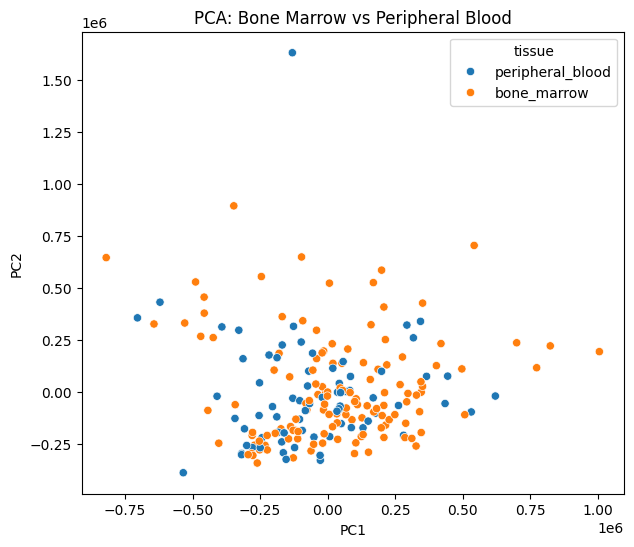

In [11]:
#generate PCA plot
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pcs = pca.fit_transform(expr.T)

pca_df = pd.DataFrame({
    "PC1": pcs[:,0],
    "PC2": pcs[:,1],
    "tissue": tissue_simple
})

plt.figure(figsize=(7,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="tissue")
plt.title("PCA: Bone Marrow vs Peripheral Blood")
plt.show()


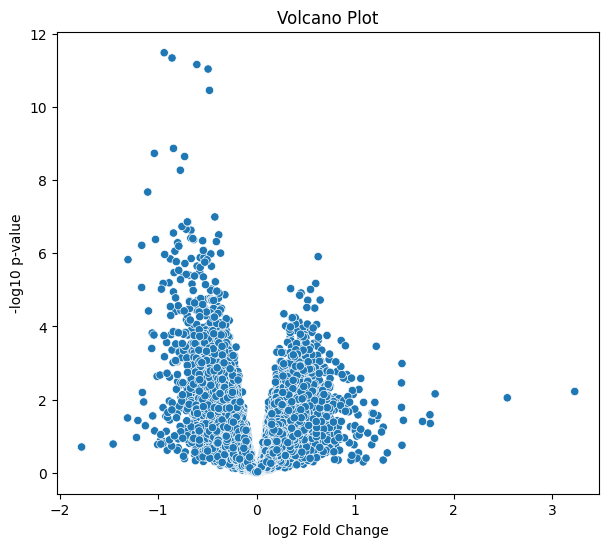

In [12]:
#volcano plot
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=DE["logFC"],
    y=-np.log10(DE["pval"]),
    hue=DE["FDR"] < 0.05,
    legend=False
)
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10 p-value")
plt.title("Volcano Plot")
plt.show()


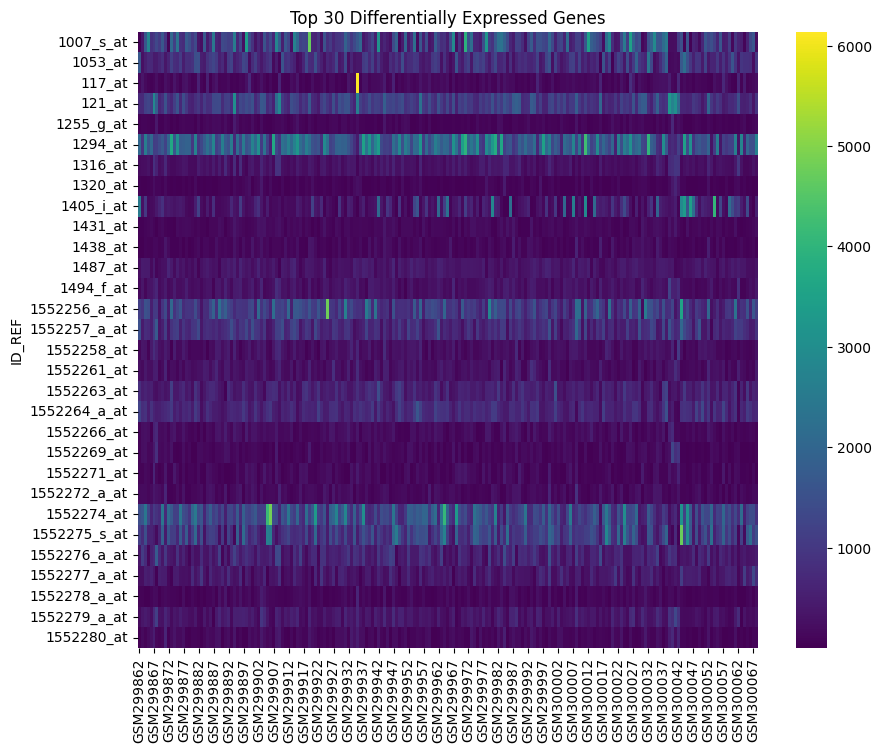

In [13]:
#Heatmap (Top 30 DE Genes)
top_genes = DE_sorted.head(30).index

plt.figure(figsize=(10,8))
sns.heatmap(expr.loc[top_genes], cmap="viridis")
plt.title("Top 30 Differentially Expressed Genes")
plt.show()


In [14]:
DE_sorted.to_csv("DE_BM_vs_PB_GSE11877.csv")

